In [2]:
from Bio import Phylo
import Bio.Phylo.Newick as Newick
from io import StringIO

import networkx as nt
import numpy as np
import matplotlib.pyplot as plt

import re

%matplotlib inline

In [1]:
def build_tree(row):
    raw_tree = np.array(row.split()).astype(np.int)
    tree = [v if v > -1 else None for v in raw_tree]
    return build(tree)

def print_tree(path):
    with open(path) as f:
        tree_str = f.readlines()[0]
    print(name, build_tree(tree_str))
    
def print_transm_net(path):
    with open(path) as f:
        text = f.readlines()
        param = int(text[0].strip())
        lines = [line.strip() for line in text[1:]]
    trans_net = nt.parse_adjlist(lines, nodetype = int)
    print("S_metric is ", param)
    print("\n Transmission network")
    nt.draw(trans_net, with_labels=True)

outbreak_name = "BB"
outbreak_type = "hepatit/"
base_path_write = "../Algorithm/Algorithm/in/" + outbreak_type + outbreak_name + "/"
base_path_read = "../Algorithm/Algorithm/out" + outbreak_type + outbreak_name + "/"

### Load raw data and look at phylogenetic tree

In [6]:
outbreak = Phylo.read("../Data/" + outbreak_type + "%s.nwk" % outbreak_name, "newick")
outbreak.ladderize()

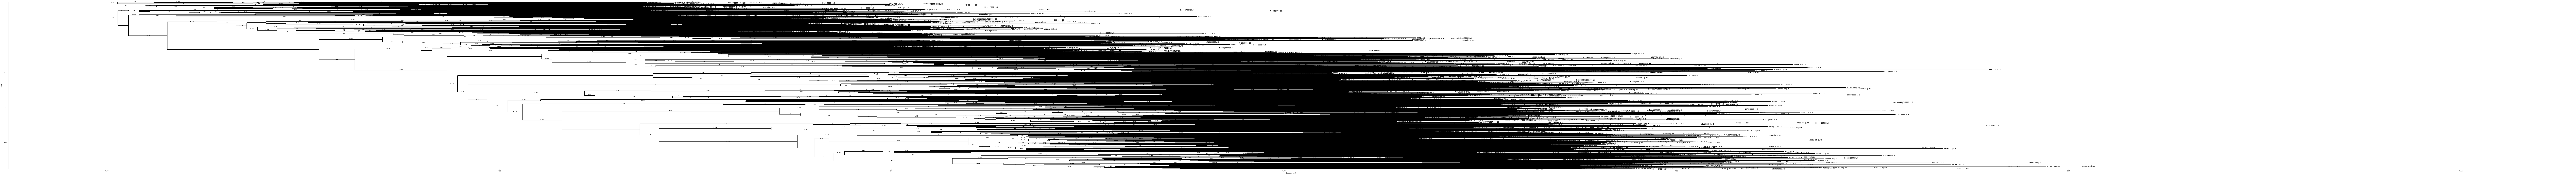

In [25]:
fig = plt.figure(figsize=(300, 20), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(outbreak, axes=axes)
#fig.savefig("AA_raw.png")

### Check if tree is completely binary (error could be within root and not be found)

In [46]:
graph = Phylo.to_networkx(outbreak)

adj_matrix = nt.to_numpy_matrix(graph)
nodes = list(graph.nodes())

for i, row in enumerate(adj_matrix):
    if (((np.count_nonzero(row)) > 3) | ((np.count_nonzero(row) > 2) & (i == 0))):
        print("Alert in %s row" % i)

Alert in 0 row
Alert in 348 row


### Convert outbreak to adj_matrix with mapping genom to their hosts

In [47]:
def create_host_adj_matrix(graph):
    adj_matrix = nt.to_numpy_matrix(graph)
    nodes = list(graph.nodes())
    
    m = re.compile("(^[A-Z]*)([0-9]*)")
    genoms = set([n.name for n in nodes if n.name])
    people = [m.match(g).group(2) for g in genoms]
    unique_people = list(set(people))
    people_to_ind = dict(zip(unique_people, range(1, len(unique_people) + 1)))
    people_ind = [people_to_ind[p] for p in people]
    gen_to_pers_ind = dict(zip(genoms, people_ind))
    
    for index, val in np.ndenumerate(adj_matrix):
        if (adj_matrix[index] != 0):
            gen = nodes[index[1]].name
            adj_matrix[index] = gen_to_pers_ind[gen] if gen else 0
        else:
            adj_matrix[index] = -1
    return (adj_matrix, people_to_ind)

In [48]:
matrix, people_to_ind = create_host_adj_matrix(graph) 

In [49]:
people_to_ind

{'41': 1, '44': 2, '3': 3, '45': 4, '42': 5, '31': 6, '1': 7, '29': 8}

### Save results

In [77]:
np.savetxt(base_path_write + "matrix.txt", matrix.astype(int), fmt="%i")

In [78]:
with open(base_path_write + "people_to_ind.txt", "w") as f:
    f.write(str(people_to_ind))

# After running algorithm

### Do s_metrics converge to a single value?

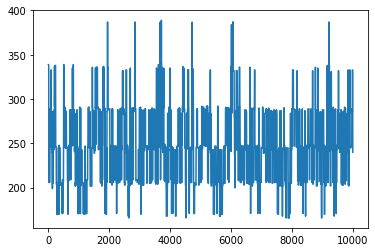

In [80]:
name = "s_metrics.txt"
with open(base_path_read + name) as f:
    line = f.readlines()[0]
s_metrics = [int(s) for s in line.split()]
plt.plot(s_metrics)

### Final transmission network

S_metric is  240

 Transmission network


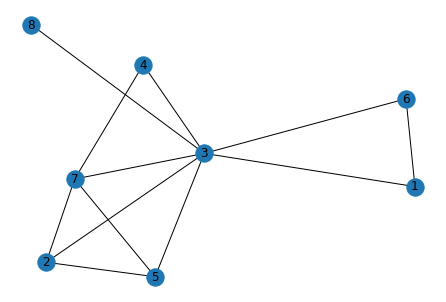

In [81]:
name = "t_net.txt"
print_transm_net(base_path_read + name)